# Prerequesits

In [1]:
#PyTorch Specific libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torchattacks

#Data manipulation and visualisation specific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Miscellaneous
import random

# Context Manager
from contextlib import nullcontext

# For Load Bar
from tqdm import tqdm

In [2]:
# Global Variables

RND = 42

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Use this method to be able to reproduce results over multiple tries
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
setup_seed(RND)

cuda:0


# Data

## Loading

In [ ]:
# TODO: Change the directory to whatever you like

#data_dir = "/home/server/Meine_Dateien/Security-and-Privacy-of-ML/Tutorials/Tutorial_3/data"
data_dir = "./data"
train_set = torchvision.datasets.CIFAR10(root=data_dir, transform=transforms.Compose([transforms.ToTensor()]), download=True, train=True)
test_set = torchvision.datasets.CIFAR10(root=data_dir, transform=transforms.Compose([transforms.ToTensor()]), download=True, train=False)
labels_dict =  {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

## Split and data loader

In [5]:
# Most stable convergence with batch = 128 and epochs = 10, shortened to 8 for highest acc
batch_size = 128
num_epochs = 8

# The extra validation set lead to worse performance, so I opted for the regular test set.
# Note that the plotting function taken from the tutorial will still refer to "val" but defacto it is the test set you're validating on.
#train_set, val_set = torch.utils.data.random_split(train_set, [40000, 10000])
#val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)



## Check

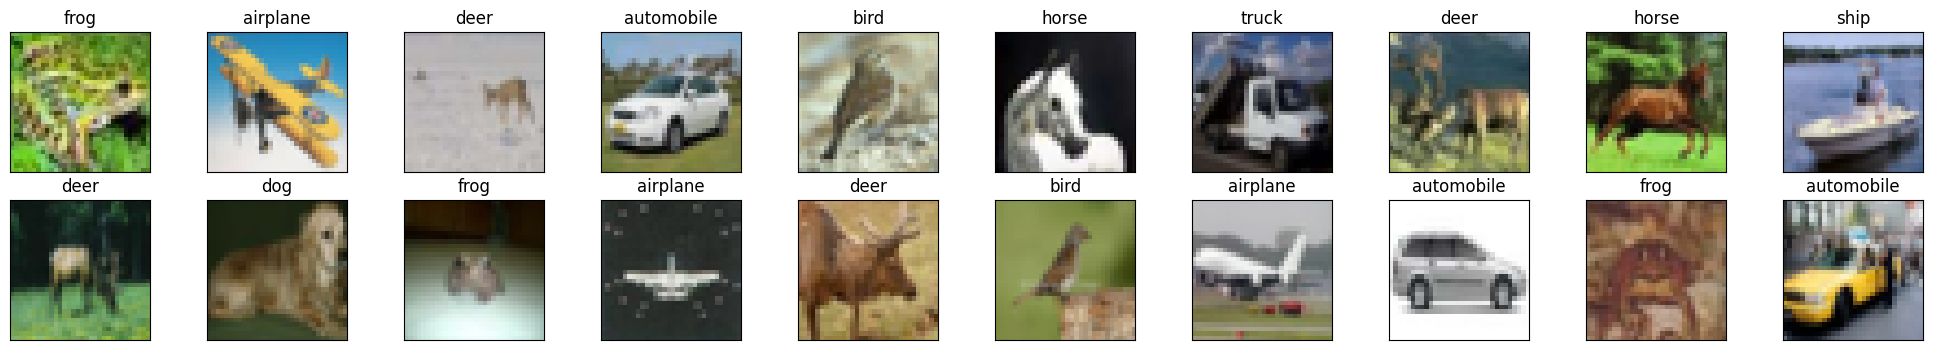

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# plot 20 images of the batch
def plot_images(images, labels):
    plt_images = images.detach().cpu()
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.transpose(plt_images[idx], (1, 2, 0)))
        ax.set_title(str(labels_dict[labels[idx].item()]))

plot_images(images, labels)

In [7]:
# Images are normalized already

print(images[0].max())
print(images[0].min())

tensor(0.9725)
tensor(0.)


# Network

## Definition

In [8]:
from torchvision.models import resnet18

# Load pre-trained ResNet-18
model = resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # Modify output layer for CIFAR-10
model = model.to(device)

# Define optimiser and criterion
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/server/miniconda3/envs/SPML/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/server/miniconda3/envs/SPML/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [9]:
# Method to compute accuracy
def accuracy(outputs,labels):
    _, preds = torch.max(outputs, dim=1)
    return (torch.tensor(torch.sum(preds == labels).item() / len(preds)))

In [10]:
def model_training(model, criterion, optimizer):
    # Execute Training
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        print("Epoch: ", epoch+1)
        
        # Training Phase
        for batch in tqdm(train_loader):
            # Prepare batch data
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            # Generate prediction
            predictions = model(images)
            # Calculate loss
            loss = criterion(predictions, labels)
            # Compute gradients
            loss.backward()
            # Update weights
            optimizer.step()
            # Reset gradients
            optimizer.zero_grad()

        # Execute Validation
        batch_val_losses = []
        batch_val_accs = []
        with torch.no_grad():
            model.eval()
            #for batch in tqdm(val_loader):
            for batch in tqdm(test_loader):
                # Prepare batch data
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)
                # Generate predictions
                predictions = model(images)
                # Calculate loss
                batch_val_loss = criterion(predictions, labels)
                # Calculate accuracy
                batch_val_acc = accuracy(predictions, labels)
                # Store batch results
                batch_val_losses.append(batch_val_loss)
                batch_val_accs.append(batch_val_acc)

        epoch_val_loss = torch.stack(batch_val_losses).mean()
        epoch_val_acc = torch.stack(batch_val_accs).mean()
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

    return val_loss, val_acc

In [11]:
val_loss, val_acc = model_training(model, criterion, optimizer)

# Using test set immediately
#print("Validation Loss: ", round(torch.stack(val_loss).mean().item(),2))
#print("Validation Accuracy: ", round(torch.stack(val_acc).mean().item()*100.0,2))  

Epoch:  1


100%|██████████| 79/79 [00:01<00:00, 72.57it/s]


Epoch:  2


100%|██████████| 79/79 [00:01<00:00, 75.24it/s]


Epoch:  3


100%|██████████| 79/79 [00:01<00:00, 75.71it/s]


Epoch:  4


100%|██████████| 79/79 [00:01<00:00, 76.02it/s]


Epoch:  5


100%|██████████| 79/79 [00:01<00:00, 75.94it/s]


Epoch:  6


100%|██████████| 79/79 [00:01<00:00, 74.73it/s]


Epoch:  7


100%|██████████| 79/79 [00:01<00:00, 75.79it/s]


Epoch:  8


100%|██████████| 79/79 [00:01<00:00, 76.41it/s]


## Testing

In [12]:
# Execute Testing
test_loss = []
test_acc = []
with torch.no_grad():
    model.eval()
    for batch in tqdm(test_loader):
        # Prepare batch data
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        # Generate predictions
        predictions = model(images)
        # Calculate loss
        batch_test_loss = criterion(predictions, labels)
        # Calculate accuracy
        batch_test_acc = accuracy(predictions, labels)
        # Store batch results
        test_loss.append(batch_test_loss)
        test_acc.append(batch_test_acc)

# Display Results
print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))

100%|██████████| 79/79 [00:01<00:00, 76.42it/s]

Test Loss:  0.67
Test Accuracy:  79.69


## Plotting

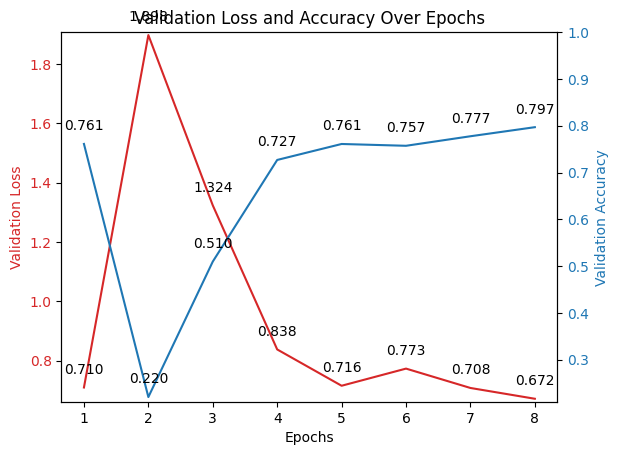

In [13]:
# Plot Training
import matplotlib.pyplot as plt

val_losses = torch.stack(val_loss).cpu()
val_accs = torch.stack(val_acc).cpu()

epochs = range(1, len(val_losses)+1)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel("Validation Loss", color="tab:red")
ax1.plot(epochs, val_losses, color="tab:red")
ax1.tick_params(axis='y', labelcolor="tab:red")

# Set y-axis range for validation loss
ax1.set_ylim([min(val_losses) - 0.01, max(val_losses) + 0.01]) 

# Annotating each point for val_loss
for i, txt in enumerate(val_losses):
    ax1.annotate(f"{txt:.3f}", (epochs[i], val_losses[i]), textcoords="offset points", xytext=(0,10), ha='center', color='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Validation Accuracy', color="tab:blue")
ax2.plot(epochs, val_accs, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Set y-axis range for validation accuracy
ax2.set_ylim([min(val_accs) - 0.01, 1.0]) 

# Annotating each point for val_acc
for i, txt in enumerate(val_accs):
    ax2.annotate(f"{txt:.3f}", (epochs[i], val_accs[i]), textcoords="offset points", xytext=(0,10), ha='center', color='black')


plt.xticks(epochs)

plt.title("Validation Loss and Accuracy Over Epochs")
plt.show()

# 1. Attacks

## a) 
(3 points) Implement and execute the untargeted and targeted version of the PGD attack. Use class cat (class index 3) as your target with epsilon values ranging from 0.0 (clean images) up to (including) 0.3 (step of 0.05). Calculate the accuracy scores and plot the accuracy drop for each epsilon value. Explain the obtained results from the experiments, focusing on accuracy values between the two attack types and varying epsilon values.

### Untargeted PGD

In [14]:
class PGD(nn.Module):
    
    def __init__(self, model, eps=8/255,
                 alpha=2/255, steps=10, random_start=True,loss=nn.CrossEntropyLoss(),device='cpu'):
        super().__init__()
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.loss = loss
        self.device = device

    def forward(self, images, labels):
        images = images.clone().detach().to(self.device)#.float()
        labels = labels.clone().detach().to(self.device)
        images.requires_grad = True

        # Placeholder for perturbed images, initially a clean image
        adv_images = images.clone().to(self.device)

        if self.random_start:
            # For a random start, add noise to the clean image
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1)
            
        # Implementation of PGD
        
        # PGD is a multi-step version of FGSM
        for _ in range(self.steps):
            # Prepare images and labels
            
            # Generate predictions
            predictions = self.model(adv_images)

            # Calculate loss
            loss = self.loss(predictions,labels)
            
            # Gradient with respect to inputs instead of weights -> which inputs cause wrong prediction?
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]

            # Update adversarial
            # in Iter1: Add perturbation to clean image
            adv_images = adv_images + self.alpha*grad.sign()
            
            # Project x_t back with torch.clamp
            # Check if perturbed image is within allowed boundary, if not clamp
            adv_images = torch.clamp(adv_images, images-self.eps, images+self.eps)
            # Make sure perturbed image is adhering to [0,1] normalisation
            adv_images = torch.clamp(adv_images, min=0, max=1)

        return adv_images

In [15]:
def plot_perturbed_images(model, images, labels):
    plt_images = images.detach().cpu()

    # Re-classify the perturbed image
    new_predictions = model(images)
    # Get the index of the max log-probability
    _, y_preds = new_predictions.max(1, keepdim=True)
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.transpose(plt_images[idx], (1, 2, 0)))
        y_true = str(labels_dict[labels[idx].item()])
        y_pred = str(labels_dict[y_preds[idx].item()])
        ax.set_title(y_true + "->" + y_pred)

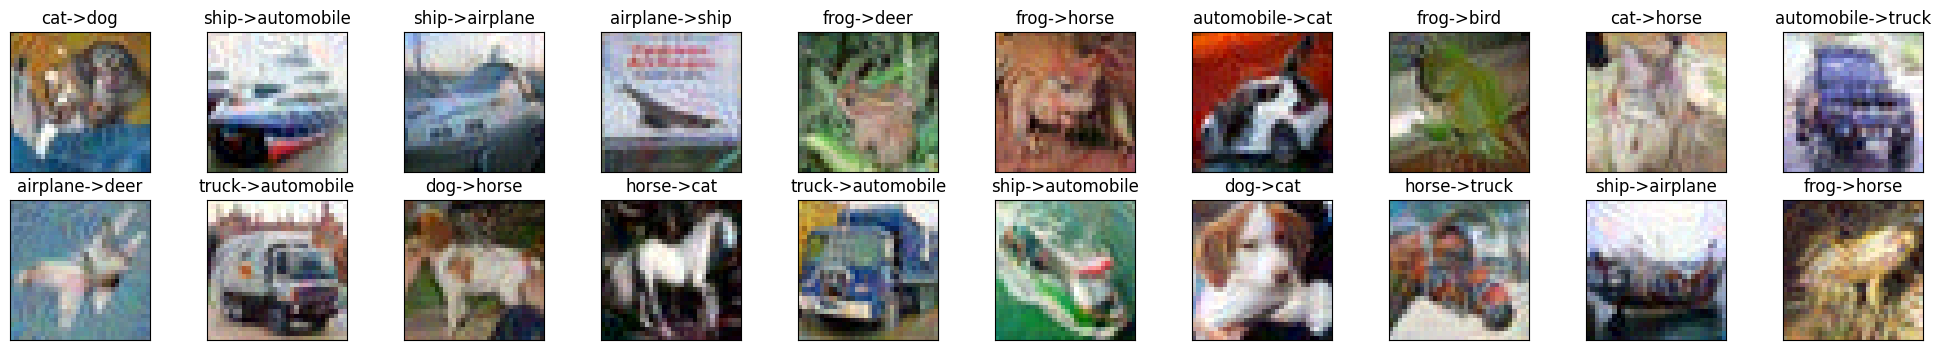

In [16]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

attack = PGD(model=model, eps=0.3, alpha=2/255, steps=10, random_start=False, device=device)
adv_images = attack(images, labels)
plot_perturbed_images(model, adv_images, labels)

In [17]:
def adv_test(model, test_loader, attack=None):
    correct = 0
    total = 0

    model.eval()
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader)):
        
        images, labels = images.to(device), labels.to(device)
        
        if attack:
            # dataloader parsing and generate adversarial examples
            images = attack(images, labels)
            
        # Evaluation
        predictions = model(images).detach()

        # Test
        _, predicted = torch.max(predictions, dim=1)
        total += labels.numel()
        correct += (predicted == labels).sum().item() 
        
    print('[Plain/Test] Acc: {:.3f}'.format(100.*correct / total))
    return correct / total

In [18]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []

for eps in epsilons:
    attack = PGD(model=model,eps=eps,loss=criterion,device=device)
    acc = adv_test(model, test_loader, attack)
    accuracies.append(acc)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:07<00:00, 11.20it/s]


[Plain/Test] Acc: 79.740


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:07<00:00, 11.25it/s]


[Plain/Test] Acc: 0.740


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:07<00:00, 11.24it/s]


[Plain/Test] Acc: 0.320


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:07<00:00, 11.24it/s]


[Plain/Test] Acc: 0.110


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:06<00:00, 11.31it/s]


[Plain/Test] Acc: 0.060


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:06<00:00, 11.32it/s]


[Plain/Test] Acc: 0.010


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:06<00:00, 11.34it/s]

[Plain/Test] Acc: 0.010


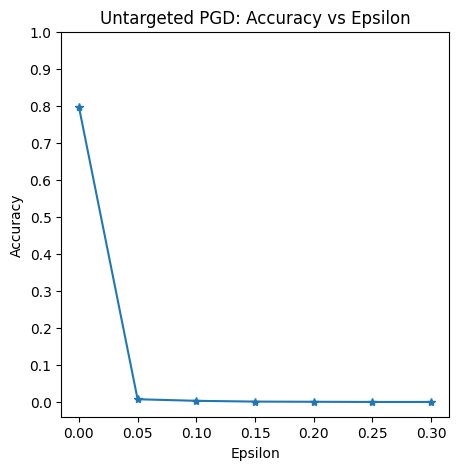

In [19]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Untargeted PGD: Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Targeted PGD

In [20]:
class PGD_targeted(nn.Module):
    
    def __init__(self, model, eps=8/255,
                 alpha=2/255, steps=10, random_start=True,loss=nn.CrossEntropyLoss(),device='cpu', target=3):
        super().__init__()
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.loss = loss
        self.device = device
        self.target = target

    def forward(self, images, labels):
        images = images.clone().detach().to(self.device)#.float()
        labels = labels.clone().detach().to(self.device)
        images.requires_grad = True
        target = torch.full_like(labels, self.target).detach().to(self.device)

        # Placeholder for perturbed images, initially a clean image
        adv_images = images.clone().to(self.device)

        if self.random_start:
            # For a random start, add noise to the clean image
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1)
            
        # Implementation of PGD
        
        # PGD is a multi-step version of FGSM
        for _ in range(self.steps):
            # Prepare images and labels
            
            # Generate predictions
            predictions = self.model(adv_images)

            # Calculate loss
            loss = self.loss(predictions, target)
            
            # Gradient with respect to inputs instead of weights -> which inputs cause wrong prediction?
            grad = torch.autograd.grad(loss, adv_images, retain_graph=False, create_graph=False)[0]

            # Update adversarial
            # in Iter1: Add perturbation to clean image
            adv_images = adv_images - self.alpha*grad.sign()
            
            # Project x_t back with torch.clamp
            # Check if perturbed image is within allowed boundary, if not clamp
            adv_images = torch.clamp(adv_images, images-self.eps, images+self.eps)
            # Make sure perturbed image is adhering to [0,1] normalisation
            adv_images = torch.clamp(adv_images, min=0, max=1)

        return adv_images

cat


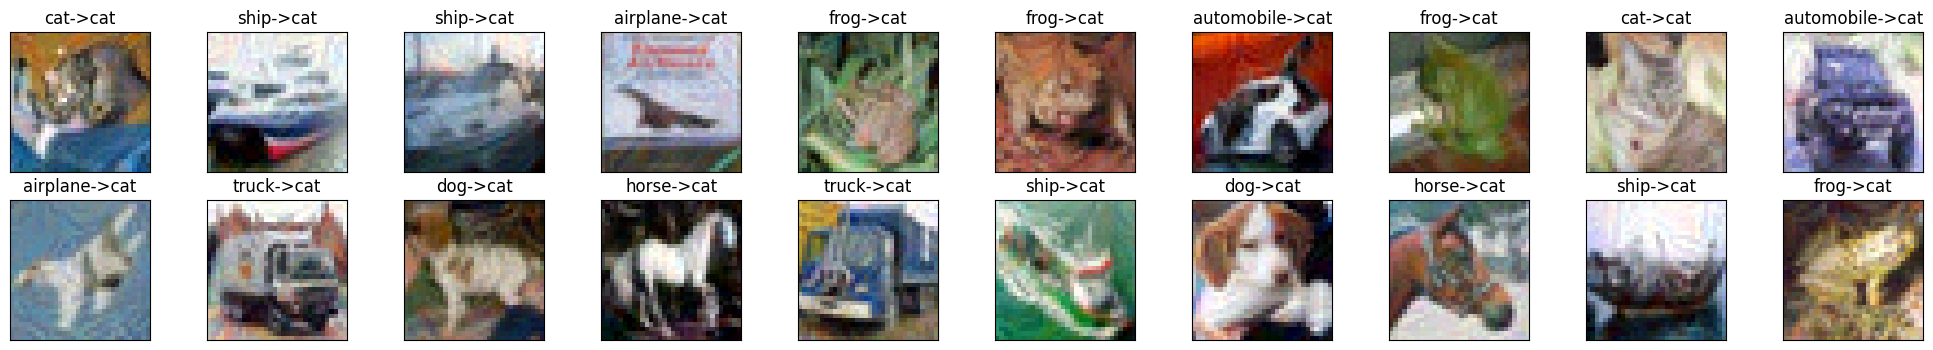

In [21]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

print(labels_dict[3])
attack = PGD_targeted(model=model, eps=0.3, alpha=2/255, steps=10, random_start=False, device=device, target=3)
adv_images = attack(images, labels)
plot_perturbed_images(model, adv_images, labels)

In [22]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []

for eps in epsilons:
    attack = PGD_targeted(model=model,eps=eps,loss=criterion,device=device, target=3)
    acc = adv_test(model, test_loader, attack)
    accuracies.append(acc)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:06<00:00, 11.31it/s]


[Plain/Test] Acc: 79.740


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:07<00:00, 11.28it/s]


[Plain/Test] Acc: 10.460


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:06<00:00, 11.32it/s]


[Plain/Test] Acc: 10.060


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:06<00:00, 11.33it/s]


[Plain/Test] Acc: 10.010


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:06<00:00, 11.31it/s]


[Plain/Test] Acc: 10.010


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:06<00:00, 11.31it/s]


[Plain/Test] Acc: 10.070


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:06<00:00, 11.29it/s]

[Plain/Test] Acc: 10.040


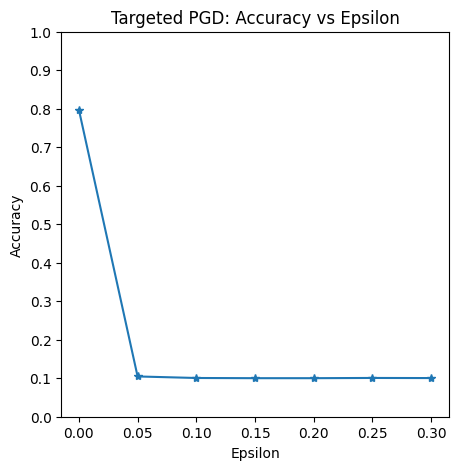

In [23]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Targeted PGD: Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Discussion

As seen in the images above, the untargeted PGD attack seems to work very well, with the accuracy dropping from over 80% to essentially 0% after for all epsilon values equal to or greater than 0.05. This is expected since the the goal of the untargeted PGD attack is to misclassify all input images, so in a good attack we expect 0% accuracy. So we maximise the loss with respect to the true input. This is why we take a step in the direction of the increasing gradient. 

The accuracy vs epsilon plot is for the targeted PGD attack is quite similar to the untargeted version, however the accuracy stays at about 10% for all epsilon greater than or equal to 0.05. This is different from the untargeted version because the goal of a targeted PGD attack is to classify an input image as a specific target (in this case class three or cat). Thus when we feed advasarial images into the model, the  model will predict class three for all inputs, and because there are 10 classes in CIFAR-10, 10% of the time the model will be correct!

## b)

(1 point) Explain the difference between the untargeted and targeted implemen- tations of the PGD attack. In what part(s) of the implementation is the targeted attack different and why?

Answer:

In the untargeted PGD attack you pass the vector containing all correct labels to the loss function of the attack. For every single image it will check if the attack was successful by comparing the predicted label to the true label. By passing the all the true labels(untargeted) PGD will try to get a misclassification on every single image.

In targeted PGD, instead of the true labels you pass the target label for all images. The goal is that the images are predicted as the target label. So instead of getting a misclassification, you actually want to get a "correct" classification towards the desired target. This is why the gradient gets a negative sign in targeted PGD compared to regular PGD.

# 2. Defenses

## a) Adversarial training
(3 points) Perform adversarial training using PGD attack. Execute and gather accuracy scores of untargeted and targeted PGD attacks on the adversarial trained model. Finally, gather accuracy scores of the untargeted and targeted PGD attack executed on a cleanly trained model (you can use your results from Q1.a). Use epsilon of 0.3 for all cases. Plot all accuracy (also from using clean test images, so no attack used) scores in one plot and compare results. Ex- plain the results obtained from the experiments, focusing on the effectiveness of defense against different attacks.

### Auxillary functions
I added the data loaders as arguments to the functions provided by you. I just prefer it stylewise.

In [24]:
def test(model, test_loader=None, attack=None):
    assert(test_loader != None)
    state = "Adv" if attack else "Plain"

    correct = 0
    total = 0
    
    model.eval()
    context_manager = nullcontext() if attack else torch.no_grad()
    with context_manager:
        print(f'\n\n[{state}/Test] Under Testing ... Please Wait')
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            if attack:
                inputs = attack(inputs, targets)
        
            # Evaluation
            #print(inputs.shape)
            #print(type(model(inputs)))
            #print(model(inputs).shape)
            outputs = model(inputs).detach()
        
            # Test
            _, predicted = torch.max(outputs, dim=1)
            total += targets.numel()
            correct += (predicted == targets).sum().item() 

    accuracy = 100.*correct / total
    print('[{}/Test] Acc: {:.3f}'.format(state,accuracy))
    return accuracy

In [25]:
def train(model, data_loaders = None, criterion = torch.nn.CrossEntropyLoss(), optimizer = optim.Adam(model.parameters(), lr=0.001), attack=None, epochs=5):
    assert(data_loaders != None)
    train_loader = data_loaders[0]
    test_loader = data_loaders[1]

    state = "Adv" if attack else "Clean"
    for epoch in range(epochs):
        print('\n\n[{}/Epoch] : {}'.format(state,epoch+1))

        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if attack:
                # Prepare adversarial examples
                inputs = attack(inputs,targets)

            # Learning network parameters
            optimizer.zero_grad()

            # Using (adversarial) examples to train
            outputs = model(inputs.type(torch.FloatTensor).to(device))

            targets = targets.to(device)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Validation
            pred = torch.max(model(inputs.type(torch.FloatTensor).to(device)).detach(), dim=1)[1]
            correct += torch.sum(pred.eq(targets)).item()
            total += targets.numel()

            running_loss += loss.item()

            if batch_idx % 50 == 0 and batch_idx != 0:
                print('[{}/Train] Iter: {}, Acc: {:.3f}, Loss: {:.3f}'.format(
                    state,
                    batch_idx, # Iter
                    100.*correct / total, # Acc
                    running_loss / (batch_idx+1) # CrossEntropy
                    )
                )
        
        # Test
        test(model, test_loader)
        test(model, test_loader, attack)

In [26]:
def save_model(model, optimizer, total_epochs, model_label):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': total_epochs
    }, model_label)

def load_resnet_cifar_model(model_label, lr=0.1):
    model = resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, 10)  # Modify output layer for CIFAR-10
    model = model.to(device)

    checkpoint = torch.load(model_label, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    current_epoch = checkpoint['epoch']  # Resume from correct epoch

    return model, optimizer, current_epoch

### Adversarial Tranining: Untargeted and targeted PGD

In [27]:
eps=0.30
alpha=0.01
lr=0.1
steps = 5
epochs = 20
total_epochs = epochs

criterion = torch.nn.CrossEntropyLoss()
data_loaders = [train_loader, test_loader]

In [28]:

try:
    model_label = f"pgd_net_eps={eps}_steps={steps}_epochs={epochs}.tar"

    # Loading pgd_net from drive
    pgd_net, optimizer, current_epoch = load_resnet_cifar_model(model_label, lr=lr)
    total_epochs = current_epoch

    # Defining attacks
    #optimizer = torch.optim.SGD(pgd_net.parameters(), lr=lr)
    attack_pgd = PGD(model=pgd_net, eps=eps, alpha=alpha, steps=steps, random_start=False, device=device)
    attack_pgd_targeted = PGD_targeted(model=pgd_net, eps=eps, alpha=alpha, steps=steps, random_start=False, device=device)

    print(f"Model found and loaded into \"pgd_net\". Current epoch = {current_epoch}")

except FileNotFoundError:
    print("No model found. Training new model now.")
    
    # Load pre-trained ResNet-18
    pgd_net = resnet18(pretrained=True)
    pgd_net.fc = torch.nn.Linear(pgd_net.fc.in_features, 10)  # Modify output layer for CIFAR-10
    pgd_net = pgd_net.to(device)

    # Defining attacks
    optimizer = torch.optim.SGD(pgd_net.parameters(), lr=lr)
    attack_pgd = PGD(model=pgd_net, eps=eps, alpha=alpha, steps=steps, random_start=False, device=device)
    attack_pgd_targeted = PGD_targeted(model=pgd_net, eps=eps, alpha=alpha, steps=steps, random_start=False, device=device)

    # Training procedure
    train(pgd_net, data_loaders, criterion, optimizer, attack=attack_pgd, epochs=epochs)

    model_label = f"pgd_net_eps={eps}_steps={steps}_epochs={epochs}.tar"
    # state_dict = pgd_net.state_dict()
    # torch.save(state_dict, model_label)

    save_model(pgd_net, optimizer, total_epochs, model_label)

Model found and loaded into "pgd_net". Current epoch = 20


/home/server/miniconda3/envs/SPML/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [29]:
# Use this if additional training is needed

# add_epochs = 5
# train(pgd_net, data_loaders, criterion, optimizer, attack=attack_pgd, epochs=add_epochs)
# total_epochs += add_epochs
# model_label = f"pgd_net_eps={eps}_steps={steps}_epochs={total_epochs}.tar"
# state_dict = pgd_net.state_dict()
# torch.save(state_dict, model_label)

### Comparison robust vs. clean model

In [30]:
pgd_net_scores = []
pgd_net_scores.append(test(pgd_net, test_loader))
pgd_net_scores.append(test(pgd_net, test_loader, attack_pgd))
pgd_net_scores.append(test(pgd_net, test_loader, attack_pgd_targeted))



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.93it/s]


[Plain/Test] Acc: 45.980


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:04<00:00, 19.55it/s]


[Adv/Test] Acc: 27.560


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:04<00:00, 19.61it/s]

[Adv/Test] Acc: 40.480


In [31]:
attack_pgd = PGD(model=model, eps=eps, alpha=alpha, steps=steps, random_start=False, device=device)
attack_pgd_targeted = PGD_targeted(model=model, eps=eps, alpha=alpha, steps=steps, random_start=False, device=device)

clean_net_scores = []
clean_net_scores.append(test(model, test_loader))
clean_net_scores.append(test(model, test_loader, attack_pgd))
clean_net_scores.append(test(model, test_loader, attack_pgd_targeted))



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.54it/s]


[Plain/Test] Acc: 79.740


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:04<00:00, 19.67it/s]


[Adv/Test] Acc: 0.930


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:04<00:00, 19.68it/s]

[Adv/Test] Acc: 11.640


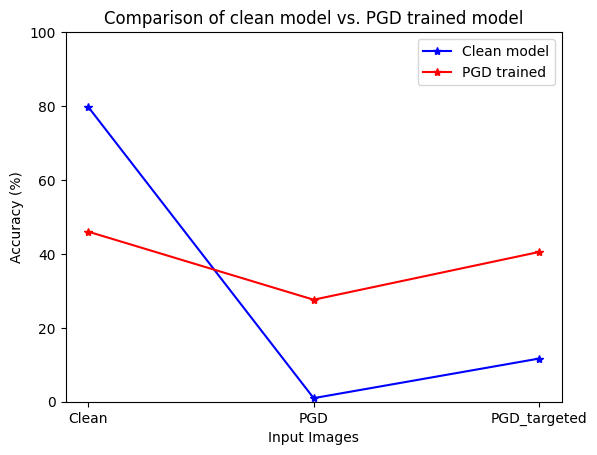

In [32]:
labels = ['Clean', 'PGD', 'PGD_targeted']

plt.plot(labels, clean_net_scores, 'b*-', label="Clean model")
plt.plot(labels, pgd_net_scores, 'r*-', label="PGD trained")
plt.ylim(ymin=0,ymax=100)
plt.ylabel("Accuracy (%)")
plt.xlabel("Input Images")
plt.title("Comparison of clean model vs. PGD trained model")
plt.legend()
plt.show()

### Discussion

Starting with the clean model, you can clearly see that Resnet-18 has good capabilities in predicting the CIFAR-10 dataset, given the ~80% accuracy. Just as capable is PGD though in attacking this model. The both attacks, untargeted as well as targeted, basically destroy any predictive power the model had. Untargeted PGD drops the the accuracy to ~1% and targeted PGD to ~10%. Latter boils down to correct predictions of the target, which is intended in the attack.

The robustness traning can mitigate these effect somewhat. PGD images can now be predicted with 27.6% which is obviously a huge improvement over no predictive power at all. The accuracy on the targeted attack is significantly higher with 40.4%, but this is probably mainly due to the intended correct prediction of the target as mentioned above. Still, the robustness training comes at a cost which can be read from the accuracy on the clean images. It drops from ~80% to mere 46%.

## b) Pruning
(2 points) Implement and execute the pruning defense as explained in the tuto- rial notebook. However, this time you use your own cleanly trained model and use the untargeted PGD as your attack. Focus on the last layer of your neural network (in the case of CNNs, use the last convolutional layer). Collect the out- put of your layer for clean and adversarial images. You then need to compute the Euclidean distances and plot them. Pick a set of channels (could be just one) and prune them. Again, gather and plot accuracy scores for using clean or adversarial images in pruning and no-pruning scenarios. Plot all results in one plot. Discuss the results, focusing on the effectiveness of this defense against the attack. Also, motivate why you selected the specific channel(s) you picked to prune.

### Information on ResNet architecture
As we worked with resnet, the pruning procedure is not as straightforward as in the tutorial.
The source code for resnet-18 can be found [here](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L54). Its not the official documentation, but code on GitHub is more readable than the actual source website.

The relevant classes to follow my code are ResNet and BasicBlock. ResNet describes the higher level architecture (including the namegiving residual connections) and BasicBlock describes what happens within such a layer. Such a BasicBlock is basically a CNN as seen in the tutorials.

From the source code, ResNet-18 is structured as follows:

**Initial layers**
- conv1 → bn1 → relu → maxpool

**Main residual blocks (each has multiple BasicBlocks)**
- layer1: 64 channels
- layer2: 128 channels
- layer3: 256 channels
- layer4: 512 channels (This is the last residual layer)

**Final layers**
- avgpool → fc

A basic block has two convolutional layers ("conv1" & "conv2") combined with batchnormalisation, relu, downsampling etc.

The pruning will be done on the second convolutional layer in the basic block of layer4 of the overall residual architecture.

#### Prunable ResNet

In [33]:
class PrunableResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(PrunableResNet18, self).__init__()

        # Load the standard ResNet-18 model
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        # Dict to store feature maps if needed
        self.record = False
        self.record_layer_outputs = {}

        # Define masks for pruning
        self.masks = {
            'layer1': None,
            'layer2': None,
            'layer3': None,
            'layer4': None
        }

    def set_record(self, record):
        self.record = record

    def set_mask(self, layer, mask):
        """Set a pruning mask for a specific layer."""
        self.masks[layer] = mask

    def get_mask(self, layer):
        """Retrieve the pruning mask for a specific layer."""
        return self.masks[layer]

    def forward(self, x):
        self.record_layer_outputs = {}  # Reset recorded outputs

        # ResNet-18 forward pass with pruning
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        # Apply pruning and recording to layers
        for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
            layer = getattr(self.resnet, layer_name)  # Get the ResNet layer
            x = layer(x)
            #print(f"Shape after {layer_name}: {x.shape}")

            # Apply pruning mask if exists
            if self.masks[layer_name] is not None:
                #print("Pruning is done")
                batch_dim = x.shape[0]
                batch_mask = self.masks[layer_name]
                batch_mask = batch_mask[0:batch_dim, :, :, :]
                x = x * batch_mask
                # x = x * self.masks[layer_name]

            # Record layer outputs if required
            if self.record:
                self.record_layer_outputs[layer_name] = x

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)

        if self.record:
            self.record = False
            return x, self.record_layer_outputs  # Return outputs for analysis
        else:
            return x


In [34]:
# Initialize model
prunable_net = PrunableResNet18().to(device)
optimizer = optim.Adam(prunable_net.resnet.parameters(), lr=0.001)
train(prunable_net, data_loaders, criterion = nn.CrossEntropyLoss(), optimizer = optimizer, epochs=8)



[Clean/Epoch] : 1
[Clean/Train] Iter: 50, Acc: 68.352, Loss: 1.460
[Clean/Train] Iter: 100, Acc: 71.156, Loss: 1.230
[Clean/Train] Iter: 150, Acc: 72.718, Loss: 1.121
[Clean/Train] Iter: 200, Acc: 74.242, Loss: 1.046
[Clean/Train] Iter: 250, Acc: 75.115, Loss: 0.997
[Clean/Train] Iter: 300, Acc: 75.901, Loss: 0.959
[Clean/Train] Iter: 350, Acc: 76.634, Loss: 0.927


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.98it/s]


[Plain/Test] Acc: 76.320


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.79it/s]


[Plain/Test] Acc: 76.320


[Clean/Epoch] : 2
[Clean/Train] Iter: 50, Acc: 85.447, Loss: 0.591
[Clean/Train] Iter: 100, Acc: 85.195, Loss: 0.604
[Clean/Train] Iter: 150, Acc: 85.001, Loss: 0.606
[Clean/Train] Iter: 200, Acc: 85.059, Loss: 0.603
[Clean/Train] Iter: 250, Acc: 85.234, Loss: 0.597
[Clean/Train] Iter: 300, Acc: 85.374, Loss: 0.590
[Clean/Train] Iter: 350, Acc: 85.457, Loss: 0.586


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.69it/s]


[Plain/Test] Acc: 78.390


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.17it/s]


[Plain/Test] Acc: 78.390


[Clean/Epoch] : 3
[Clean/Train] Iter: 50, Acc: 90.732, Loss: 0.426
[Clean/Train] Iter: 100, Acc: 90.432, Loss: 0.436
[Clean/Train] Iter: 150, Acc: 90.542, Loss: 0.435
[Clean/Train] Iter: 200, Acc: 90.466, Loss: 0.440
[Clean/Train] Iter: 250, Acc: 90.326, Loss: 0.446
[Clean/Train] Iter: 300, Acc: 90.215, Loss: 0.450
[Clean/Train] Iter: 350, Acc: 90.106, Loss: 0.451


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 76.26it/s]


[Plain/Test] Acc: 79.320


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 76.00it/s]


[Plain/Test] Acc: 79.320


[Clean/Epoch] : 4
[Clean/Train] Iter: 50, Acc: 94.378, Loss: 0.315
[Clean/Train] Iter: 100, Acc: 94.261, Loss: 0.321
[Clean/Train] Iter: 150, Acc: 94.107, Loss: 0.330
[Clean/Train] Iter: 200, Acc: 93.816, Loss: 0.337
[Clean/Train] Iter: 250, Acc: 93.638, Loss: 0.346
[Clean/Train] Iter: 300, Acc: 93.423, Loss: 0.354
[Clean/Train] Iter: 350, Acc: 93.323, Loss: 0.356


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 76.24it/s]


[Plain/Test] Acc: 80.970


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 76.07it/s]


[Plain/Test] Acc: 80.970


[Clean/Epoch] : 5
[Clean/Train] Iter: 50, Acc: 96.553, Loss: 0.236
[Clean/Train] Iter: 100, Acc: 96.736, Loss: 0.245
[Clean/Train] Iter: 150, Acc: 96.534, Loss: 0.253
[Clean/Train] Iter: 200, Acc: 96.339, Loss: 0.261
[Clean/Train] Iter: 250, Acc: 96.150, Loss: 0.268
[Clean/Train] Iter: 300, Acc: 96.042, Loss: 0.274
[Clean/Train] Iter: 350, Acc: 95.907, Loss: 0.278


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.14it/s]


[Plain/Test] Acc: 80.610


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.31it/s]


[Plain/Test] Acc: 80.610


[Clean/Epoch] : 6
[Clean/Train] Iter: 50, Acc: 97.702, Loss: 0.184
[Clean/Train] Iter: 100, Acc: 97.726, Loss: 0.200
[Clean/Train] Iter: 150, Acc: 97.708, Loss: 0.201
[Clean/Train] Iter: 200, Acc: 97.567, Loss: 0.208
[Clean/Train] Iter: 250, Acc: 97.510, Loss: 0.213
[Clean/Train] Iter: 300, Acc: 97.410, Loss: 0.219
[Clean/Train] Iter: 350, Acc: 97.362, Loss: 0.223


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.13it/s]


[Plain/Test] Acc: 80.650


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.89it/s]


[Plain/Test] Acc: 80.650


[Clean/Epoch] : 7
[Clean/Train] Iter: 50, Acc: 98.468, Loss: 0.149
[Clean/Train] Iter: 100, Acc: 98.685, Loss: 0.152
[Clean/Train] Iter: 150, Acc: 98.660, Loss: 0.155
[Clean/Train] Iter: 200, Acc: 98.585, Loss: 0.161
[Clean/Train] Iter: 250, Acc: 98.571, Loss: 0.163
[Clean/Train] Iter: 300, Acc: 98.456, Loss: 0.169
[Clean/Train] Iter: 350, Acc: 98.308, Loss: 0.174


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.87it/s]


[Plain/Test] Acc: 79.290


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.21it/s]


[Plain/Test] Acc: 79.290


[Clean/Epoch] : 8
[Clean/Train] Iter: 50, Acc: 99.020, Loss: 0.128
[Clean/Train] Iter: 100, Acc: 99.080, Loss: 0.128
[Clean/Train] Iter: 150, Acc: 99.064, Loss: 0.131
[Clean/Train] Iter: 200, Acc: 99.044, Loss: 0.134
[Clean/Train] Iter: 250, Acc: 98.942, Loss: 0.141
[Clean/Train] Iter: 300, Acc: 98.918, Loss: 0.143
[Clean/Train] Iter: 350, Acc: 98.892, Loss: 0.145


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.82it/s]


[Plain/Test] Acc: 81.170


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.63it/s]

[Plain/Test] Acc: 81.170


#### Distance calculation with PrunableResNet

In [35]:
def compute_distance_output_layer(net, attack, layer="layer4"):
    """Compute feature distance between clean and adversarial samples for a specific layer (e.g., layer4)."""
    
    # Dynamically extract the number of output channels in layer4
    #num_channels = net.resnet.layer4[-1].conv2.out_channels  # Automatically adapt to ResNet variant
    num_channels = getattr(net.resnet, layer)[-1].conv2.out_channels  
    
    distance_results = [0 for _ in range(num_channels)]  # Adapt to dynamic number of channels
    topn = 1  # Top-N selection

    for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        inputs, targets = inputs.to(device), targets.to(device)

        # Enable feature recording
        net.set_record(True)

        # Get clean feature maps
        clean_output, clean_features = net(inputs)

        # Generate adversarial examples
        adv_inputs = attack(inputs, targets)

        # Get adversarial feature maps
        net.set_record(True)
        adv_output, adv_features = net(adv_inputs)

        # Extract features from layer4
        clean_layer_features = clean_features[layer].view(inputs.shape[0], num_channels, -1) 
        adv_layer_features = adv_features[layer].view(inputs.shape[0], num_channels, -1) 

        # Iterate over the batch
        for data_id in range(inputs.shape[0]):
            distance_tensor = torch.zeros(num_channels).to(device)  # Adjust for variable channels
            
            for feature_id in range(num_channels):
                # Compute Euclidean distance per feature channel
                distance = (clean_layer_features[data_id, feature_id] - adv_layer_features[data_id, feature_id]).pow(2).sum().sqrt()
                distance_tensor[feature_id] = distance

            # Record top-N largest distances
            for feature_id in torch.topk(distance_tensor, topn)[1]:
                distance_results[feature_id] += 1
                
    return distance_results

In [36]:
prune_layer = "layer1"
distance_results = compute_distance_output_layer(prunable_net, attack_pgd, layer=prune_layer)

100%|██████████| 79/79 [00:47<00:00,  1.66it/s]


### Note: Why layer1 was chosen

Though the assignment suggests to choose the latest layer, which probably has the best performance/ robustness tradeoff, we chose to work with layer1, simply because the computation was much faster and got decent results.

The code is written almost completely dynamically. If one was to adjust the layer, you would need to adjust the masking dimensions though as the feature dimensions differ.
- layer1 -> 8,8
- layer2 -> 4,4
- layer3 -> 2,2
- layer4 -> 1,1

### Plotting distance channels

In [37]:
def plot_distances(dis_results, channels):
    data = []
    for i, count in enumerate(dis_results):
        for _ in range(count):
            data.append(i)
    bins=np.arange(channels)-0.5
    plt.figure()
    plt.hist(data,bins=bins)
    plt.xlim([-1,channels+2])
    plt.show()

Number of channels in layer1: 64


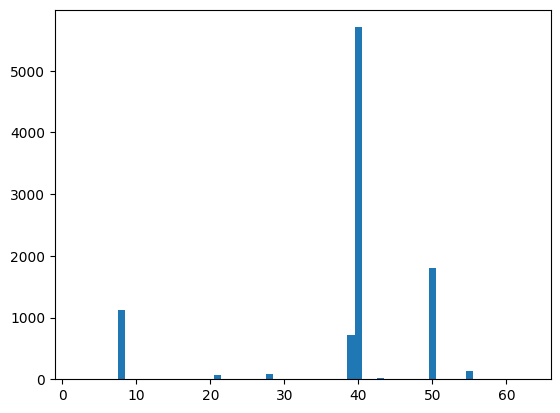

In [38]:
num_channels = getattr(prunable_net.resnet, prune_layer)[-1].conv2.out_channels  
print(f"Number of channels in {prune_layer}: {num_channels}")  # Should print 512 for ResNet-18

plot_distances(distance_results, num_channels)

### Identifying channels with largest potential

In [44]:
top_n = 8

# Convert distance_results to a tensor if it's a list
distance_tensor = torch.tensor(distance_results)

# Get the top 3 largest values and their indices
top_values, top_indices = torch.topk(distance_tensor, top_n)

# Convert to Python lists for easier handling
top_values = top_values.tolist()
top_indices = top_indices.tolist()

print(f"Top {top_n} largest values: {top_values}")
print(f"Corresponding indices: {top_indices}")


Top 8 largest values: [5705, 1803, 1130, 719, 298, 139, 90, 71]
Corresponding indices: [40, 50, 8, 39, 63, 55, 28, 21]


In [45]:
# Generate a pruning mask
# TODO: Adjust feature dimension dynamically
mask = torch.ones(batch_size, num_channels, 8, 8).to(device)  
remove_ids = top_indices  # Example indices to prune

# Set the selected channels to zero
for i in remove_ids:
    mask[:, i, :, :] = 0

In [46]:
# Reset mask (all ones) for clean evaluation

# TODO: Adjust feature dimensino dynamically
prunable_net.set_mask(prune_layer, torch.ones(batch_size, num_channels, 8, 8).to(device))

clean_acc = test(prunable_net, test_loader)  # Evaluate clean accuracy
adv_acc = test(prunable_net, test_loader, attack_pgd)  # Evaluate adversarial accuracy

print(f"Clean Accuracy (Before Pruning): {clean_acc}")
print(f"Adversarial Accuracy (Before Pruning): {adv_acc}")

# Apply the pruning mask again
prunable_net.set_mask(prune_layer, mask)

clean_acc_pruned = test(prunable_net, test_loader)  # Evaluate clean accuracy after pruning
adv_acc_pruned = test(prunable_net, test_loader, attack_pgd)  # Evaluate adversarial accuracy after pruning

print(f"Clean Accuracy (After Pruning): {clean_acc_pruned}")
print(f"Adversarial Accuracy (After Pruning): {adv_acc_pruned}")




[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 73.31it/s]


[Plain/Test] Acc: 81.170


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:04<00:00, 19.58it/s]


[Adv/Test] Acc: 8.530
Clean Accuracy (Before Pruning): 81.17
Adversarial Accuracy (Before Pruning): 8.53


[Plain/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:01<00:00, 75.71it/s]


[Plain/Test] Acc: 72.790


[Adv/Test] Under Testing ... Please Wait


100%|██████████| 79/79 [00:04<00:00, 19.69it/s]

[Adv/Test] Acc: 19.320
Clean Accuracy (After Pruning): 72.79
Adversarial Accuracy (After Pruning): 19.32


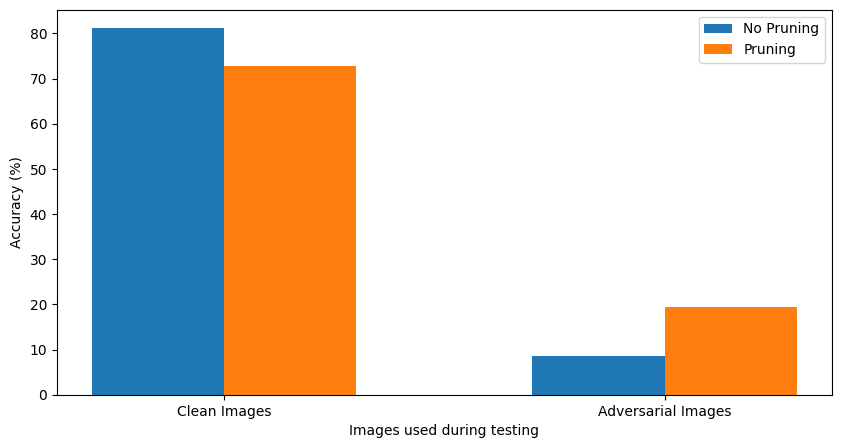

In [47]:
no_pruning = [clean_acc, adv_acc]
pruning = [clean_acc_pruned, adv_acc_pruned]

ind = np.arange(2)

plt.figure(figsize=(10,5))

width=0.3

plt.bar(ind,no_pruning, width, label='No Pruning')
plt.bar(ind+width,pruning,width,label="Pruning")

plt.xlabel('Images used during testing')
plt.ylabel('Accuracy (%)')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('Clean Images', 'Adversarial Images'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

### Discussion of pruning

The pruned channels were chosen dynamically to pick the top_n=8 channels with the largest difference to the clean model. The idea is that these channels contribute mostly to the misclassification induced by PGD. They still might contribute to correct classification though which can be seen from decreased performance on clean images with pruned channels.
But more importantly the pruning showed significant improvement on the adversarial images with almost doubling the accuracy.

## c) Defense via inputs
(1 point) If you as a developer should implement a defense, but you can only change the input to your model. What kind of defense would you apply and why? Name one defense and explain how it works and why then this fits this requirement (of only changing the input).

Answer:

This question hints to input transformation as a form of defense. This can work via compression of the inputs or adding gaussian noise to them. The idea stems from the fact that the perturbations done to adversarial images themselves look similar to noise.

When a compression is applied to the adversarial images, it might benefit performance as this adversarial noise might be lost during the compression process. Adding gaussian noise is supposed to cancel out the adversarial noise and that way end up with an image closer to the original.

# Omitted code

#### Distance calculation via hook

In [48]:
def get_intermediate_feature_hook(features_dict, layer_name):
    """ Returns a hook function that stores the output of a given layer in a dictionary. """
    def hook(module, input, output):
        features_dict[layer_name] = output
    return hook

channels = 512

def compute_distance_output_conv2(model, attack, test_loader):
    distance_results = [0 for _ in range(channels)]  # channels feature channels in ResNet-18 layer2
    topn = 1

    # Dictionary to store features
    clean_features = {}
    adv_features = {}

    # Register hook for the second convolutional block (ResNet layer4)
    hook = model.layer4.register_forward_hook(get_intermediate_feature_hook(clean_features, 'conv2'))

    for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        inputs, targets = inputs.to(device), targets.to(device)

        # Get the output of convolutional layer 4 with clean inputs   
        model(inputs)  # Forward pass
        clean_conv2_features = clean_features['conv2']  # Extract saved feature map

        # Generate adversarial examples
        adv_inputs = attack(inputs, targets)

        # Get the output of convolutional layer 4 with adversarial inputs   
        model(adv_inputs)  # Forward pass
        adv_conv2_features = clean_features['conv2']  # Extract adversarial feature map

        # Reshape: Flatten 8x8 spatial dimensions into a single vector per channel
        batch_size = clean_conv2_features.shape[0]  # Get actual batch size (might not be 100)
        clean_conv2_features = clean_conv2_features.view(batch_size, channels, -1)  # Shape: [batch, channels, channels]
        adv_conv2_features = adv_conv2_features.view(batch_size, channels, -1)  # Shape: [batch, channels, channels]

        # Compute feature distances
        for data_id in range(batch_size):
            distance_tensor = torch.zeros(channels).to(device)  # channels feature channels in ResNet-18 layer2
            for feature_id in range(channels):
                # Compute Euclidean distance for each feature channel
                distance = (clean_conv2_features[data_id][feature_id] - adv_conv2_features[data_id][feature_id]).pow(2).sum().sqrt()
                distance_tensor[feature_id] = distance

            # Record topn highest distances
            for feature_id in torch.topk(distance_tensor, topn)[1]:
                distance_results[feature_id] += 1

    # Remove the hook after we're done
    hook.remove()
    
    return distance_results

distance_results = compute_distance_output_conv2(model, attack_pgd, test_loader)

  4%|▍         | 3/79 [00:15<06:25,  5.07s/it]


KeyboardInterrupt: 

In [ ]:
print(len(distance_results))

In [ ]:
channels = 512
plot_distances(distance_results, channels)

In [ ]:
# Convert distance_results to a tensor if it's a list
distance_tensor = torch.tensor(distance_results)

# Get the top 3 largest values and their indices
top_values, top_indices = torch.topk(distance_tensor, 5)

# Convert to Python lists for easier handling
top_values = top_values.tolist()
top_indices = top_indices.tolist()

print(f"Top 3 largest values: {top_values}")
print(f"Corresponding indices: {top_indices}")
